In [1]:
import gzip
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from nunet.nn import MLP
from nunet.optim import SGD
from nunet.loss import CategoricalCrossEntropyLoss

In [2]:
with gzip.open('data/sample_mnist.pkl.gz', 'rb') as f:
    loaded_dict = pickle.load(f)

X = loaded_dict['X']
y = loaded_dict['y']


Shape of X:  (10000, 784)
Shape of y:  (10000,)
Number of unique labels:  10


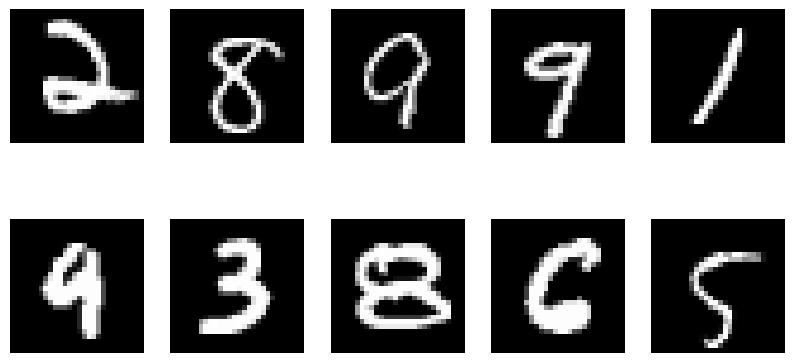

In [3]:
# Data exploration of mnist dataset
print("Shape of X: ", X.shape)
print("Shape of y: ", y.shape)

print("Number of unique labels: ", len(np.unique(y)))

# Plot some examples from the dataset
fig, ax = plt.subplots(2, 5, figsize=(10, 5))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(X[np.random.randint(0, len(X))].reshape(28, 28), cmap='gray')
        ax[i, j].axis('off')

In [4]:
# Convert to one-hot encoding
y_onehot = np.zeros((len(y), 10))
y_onehot[np.arange(len(y)), y.astype(int)] = 1

X_train, X_test, y_train, y_test = train_test_split(
        X, y_onehot, test_size=0.3, random_state=42, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train, test_size=0.3, random_state=42, stratify=y_train, shuffle=True)
    
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 4900
Validation set size: 2100
Test set size: 3000


In [5]:
# Data Normalization
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [7]:
# Learning rate scheduler
class LearningRateScheduler:
    def __init__(self, initial_lr, decay_factor=0.95, min_lr=1e-6):
        self.lr = initial_lr
        self.decay_factor = decay_factor
        self.min_lr = min_lr
        
    def step(self, val_loss=None, patience_counter=0):
        """Reduce learning rate if validation loss plateaus"""
        if patience_counter > 0:
            self.lr = max(self.lr * self.decay_factor, self.min_lr)
        return self.lr

In [8]:
input_dim = X_train.shape[1]
hidden_dims = [64, 32]  
output_dim = y_train.shape[1]
batch_size = 32
epochs = 100
patience = 6  

In [9]:
initial_learning_rate = 0.0001


In [10]:
model = MLP(
        input_dim=input_dim,
        hidden_dims=hidden_dims, 
        output_dim=output_dim,
        init_method='normal',
        activation='relu',
        verbose=False
    )

In [11]:
# Create optimizer with gradient clipping
lr_scheduler = LearningRateScheduler(initial_learning_rate, decay_factor=0.92)
optimizer = SGD(model.param, lr=initial_learning_rate, clip_value=0.5)
# Use from_logits=True since we're working with raw outputs
loss_fn = CategoricalCrossEntropyLoss(from_logits=True)

In [12]:
# Track losses and metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
learning_rates = []

best_val_loss_value = float('inf')
best_model_state = None  # Store best model parameters
epochs_no_improve = 0

In [13]:
for epoch in range(epochs):
    # Update learning rate based on patience counter
    current_lr = lr_scheduler.step(patience_counter=epochs_no_improve)
    optimizer.lr = current_lr
    learning_rates.append(current_lr)
    
    # Shuffle training data
    indices = np.random.permutation(len(X_train))
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]
    
    # Training batches
    epoch_loss = 0
    batch_count = 0
    
    for i in range(0, len(X_train_shuffled), batch_size):
        X_batch = X_train_shuffled[i:i+batch_size]
        y_batch = y_train_shuffled[i:i+batch_size]
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass - get raw outputs
        raw_outputs = model.forward(X_batch)
        
        # Compute loss directly with from_logits=True
        loss_value = loss_fn(raw_outputs, y_batch)
        epoch_loss += loss_value
        batch_count += 1
        
        # Backward pass
        gradwrtpred = loss_fn.backward()
        model.backward(gradwrtoutput=gradwrtpred)
        
        # Update weights
        optimizer.step()
    
    # Average training loss
    avg_train_loss = epoch_loss / batch_count if batch_count > 0 else float('inf')
    train_losses.append(avg_train_loss)
    
    # Validation
    with np.errstate(all='ignore'):  # Suppress numpy warnings
        val_outputs = model.forward(X_val)
        val_loss = loss_fn(val_outputs, y_val)
        val_losses.append(val_loss)
    
    # Calculate train and validation accuracy
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    train_accuracy = accuracy_score(y_train.argmax(axis=1), train_preds.argmax(axis=1)) * 100
    val_accuracy = accuracy_score(y_val.argmax(axis=1), val_preds.argmax(axis=1)) * 100
    
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch+1}/{epochs}: Train loss={avg_train_loss:.4f}, Val loss={val_loss:.4f}, LR={current_lr:.6f}")
    print(f"Train accuracy: {train_accuracy:.2f}%, Val accuracy: {val_accuracy:.2f}%")
    
    # Store best model
    if val_loss < best_val_loss_value:
        best_val_loss_value = val_loss
        # Deep copy of model parameters (simple implementation)
        best_model_state = []
        for p in model.param:
            if isinstance(p, np.ndarray):
                best_model_state.append(np.copy(p))
            elif isinstance(p, list):
                copied_list = []
                for item in p:
                    if isinstance(item, np.ndarray):
                        copied_list.append(np.copy(item))
                    else:
                        copied_list.append(item)
                best_model_state.append(copied_list)
            else:
                best_model_state.append(p)
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
    
    # Early stopping check
    if epochs_no_improve >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
    
    # Check class distribution of predictions periodically
    if epoch % 5 == 0 or epoch == epochs - 1:
        val_class_counts = np.bincount(val_preds.argmax(axis=1), minlength=10)
        print(f"Validation class distribution: {val_class_counts}")


Epoch 1/100: Train loss=2.4020, Val loss=2.4308, LR=0.000100
Train accuracy: 9.14%, Val accuracy: 8.29%
Validation class distribution: [ 84   0   2  31 587  52  93 229 906 116]
Epoch 2/100: Train loss=2.3872, Val loss=2.4162, LR=0.000100
Train accuracy: 9.31%, Val accuracy: 8.38%
Epoch 3/100: Train loss=2.3735, Val loss=2.4026, LR=0.000100
Train accuracy: 9.59%, Val accuracy: 8.43%
Epoch 4/100: Train loss=2.3609, Val loss=2.3897, LR=0.000100
Train accuracy: 9.71%, Val accuracy: 8.62%
Epoch 5/100: Train loss=2.3510, Val loss=2.3775, LR=0.000100
Train accuracy: 10.14%, Val accuracy: 8.81%
Epoch 6/100: Train loss=2.3389, Val loss=2.3659, LR=0.000100
Train accuracy: 10.41%, Val accuracy: 9.24%
Validation class distribution: [121   0   8  81 508  76 122 274 773 137]
Epoch 7/100: Train loss=2.3278, Val loss=2.3550, LR=0.000100
Train accuracy: 10.65%, Val accuracy: 9.24%
Epoch 8/100: Train loss=2.3181, Val loss=2.3445, LR=0.000100
Train accuracy: 10.76%, Val accuracy: 9.57%
Epoch 9/100: Train

In [14]:
# Restore best model parameters
if best_model_state is not None:
    for i, p in enumerate(best_model_state):
        if isinstance(p, np.ndarray) and isinstance(model.param[i], np.ndarray):
            model.param[i][:] = p[:]  # Copy values to original parameters
        elif isinstance(p, list) and isinstance(model.param[i], list):
            for j, item in enumerate(p):
                if isinstance(item, np.ndarray) and j < len(model.param[i]):
                    if isinstance(model.param[i][j], np.ndarray):
                        model.param[i][j][:] = item[:]

In [15]:
# Final evaluation
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)

train_accuracy = accuracy_score(y_train.argmax(axis=1), train_preds.argmax(axis=1)) * 100
val_accuracy = accuracy_score(y_val.argmax(axis=1), val_preds.argmax(axis=1)) * 100

print(f"\nFinal results (best model):")
print(f"Train accuracy: {train_accuracy:.2f}%")
print(f"Validation accuracy: {val_accuracy:.2f}%")


Final results (best model):
Train accuracy: 50.59%
Validation accuracy: 48.76%


In [16]:
# Evaluate on test set
test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test.argmax(axis=1), test_pred.argmax(axis=1)) * 100
print(f"\nTest accuracy: {test_accuracy:.2f}%")


Test accuracy: 49.50%


In [17]:
y_true = y_test.argmax(axis=1)
y_pred = test_pred.argmax(axis=1)
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.86      0.73       296
           1       0.60      0.94      0.74       337
           2       0.44      0.50      0.47       300
           3       0.35      0.69      0.47       306
           4       0.61      0.11      0.18       292
           5       0.35      0.15      0.21       271
           6       0.56      0.54      0.55       295
           7       0.52      0.54      0.53       313
           8       0.33      0.21      0.25       292
           9       0.52      0.31      0.39       298

    accuracy                           0.49      3000
   macro avg       0.49      0.48      0.45      3000
weighted avg       0.49      0.49      0.46      3000



In [18]:
# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot learning curves
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

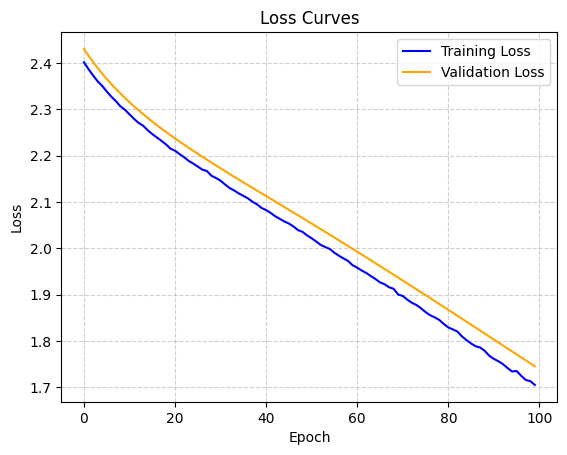

In [22]:
# Plot loss curves
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

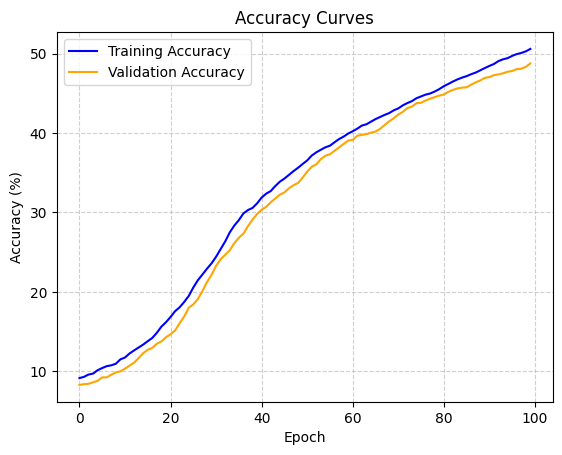

In [23]:
# Plot accuracy curves
plt.plot(train_accuracies, label='Training Accuracy', color='blue')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

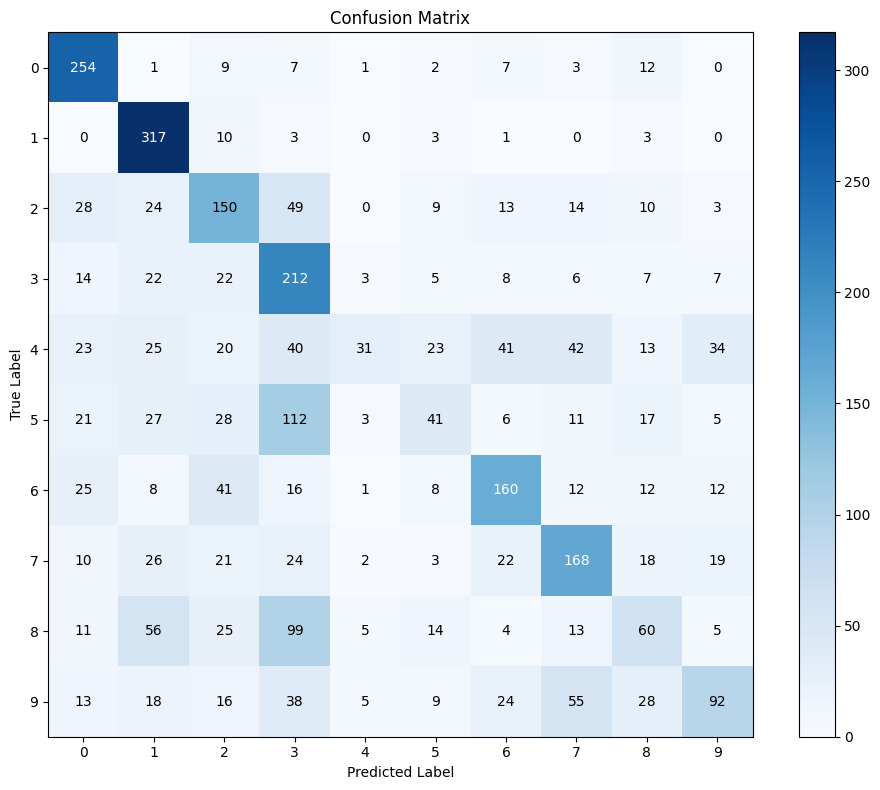

In [26]:
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(10)
plt.xticks(tick_marks, range(10))
plt.yticks(tick_marks, range(10))
# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm[i, j] > thresh else "black"
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color=color)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()